<a href="https://colab.research.google.com/github/aliakbarbadri/nlp-tf/blob/master/week3/week3-exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kazanova/sentiment140
! unzip sentiment140.zip 
! kaggle datasets download -d terenceliu4444/glove6b100dtxt
! unzip glove6b100dtxt.zip

 90% 73.0M/80.9M [00:02<00:00, 27.7MB/s]
100% 80.9M/80.9M [00:02<00:00, 39.1MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  
 92% 121M/131M [00:02<00:00, 38.4MB/s]
100% 131M/131M [00:03<00:00, 45.4MB/s]
Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [0]:
import json
import tensorflow as tf
import pandas as pd
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [4]:
csv = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding='latin-1',header=None,usecols=[0,5])
csv.columns = ['label','tweet']
csv.head(5)

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
csv.dtypes

label     int64
tweet    object
dtype: object

In [6]:
pd.unique(csv['label'])

array([0, 4])

In [7]:
csv['label'].replace({4: 1}, inplace=True)
pd.unique(csv['label'])

array([0, 1])

In [0]:
num_sentences = csv.shape[0]
corpus = csv

In [9]:
print(csv.shape[0])
print(list(csv.loc[1]))

# Expected Output:
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
[0, "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]


In [10]:
csv = csv.sample(frac = 1).reset_index(drop=True)
list(csv.loc[1])

[0, 'i thought that was it. ']

In [0]:
embedding_dim = 100
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000
test_portion=.1

In [0]:
sentences = list(csv['tweet'])[:training_size]
labels= list(csv['label'])[:training_size]


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = np.array(padded[:split])
training_sequences = np.array(padded[split:])
test_labels = np.array(labels[:split])
training_labels = np.array(labels[split:])

In [36]:
split, len(sentences), len(training_sequences), len(test_sequences)

(16000, 160000, 144000, 16000)

In [37]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138737
# 1

138766
1


In [0]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [39]:
print(len(embeddings_matrix))
# Expected Output
# 138738

138767


In [40]:
embeddings_matrix.shape

(138767, 100)

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 32, 100)           13876700  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32, 128)           84480     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 14,006,621
Trainable params: 129,921
Non-trainable params: 13,876,700
_________________________________________________________________


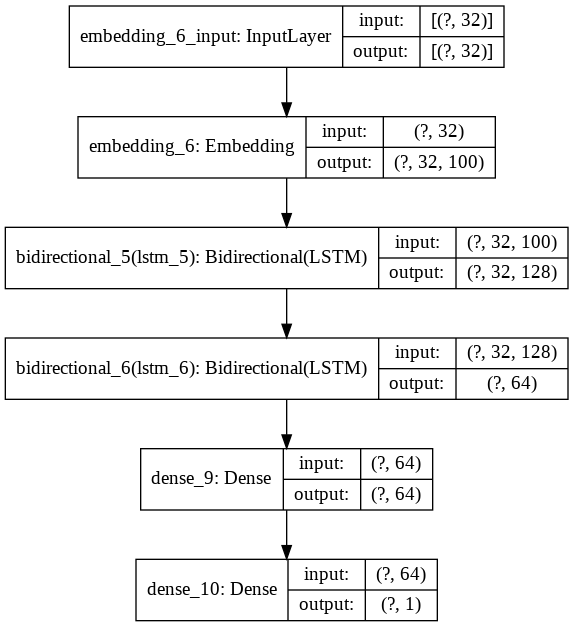

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [52]:
num_epochs = 20
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

Epoch 1/20
4500/4500 [==============================] - 47s 10ms/step - loss: 0.5153 - accuracy: 0.7416 - val_loss: 0.4911 - val_accuracy: 0.7708
Epoch 2/20
4500/4500 [==============================] - 49s 11ms/step - loss: 0.4557 - accuracy: 0.7826 - val_loss: 0.4597 - val_accuracy: 0.7813
Epoch 3/20
4500/4500 [==============================] - 47s 10ms/step - loss: 0.4268 - accuracy: 0.8008 - val_loss: 0.4416 - val_accuracy: 0.7945
Epoch 4/20
4500/4500 [==============================] - 46s 10ms/step - loss: 0.4032 - accuracy: 0.8133 - val_loss: 0.4412 - val_accuracy: 0.7979
Epoch 5/20
4500/4500 [==============================] - 46s 10ms/step - loss: 0.3816 - accuracy: 0.8250 - val_loss: 0.4465 - val_accuracy: 0.7962
Epoch 6/20
4500/4500 [==============================] - 46s 10ms/step - loss: 0.3598 - accuracy: 0.8377 - val_loss: 0.4469 - val_accuracy: 0.7956
Epoch 7/20
4500/4500 [==============================] - 46s 10ms/step - loss: 0.3381 - accuracy: 0.8489 - val_loss: 0.4827 -

<Figure size 432x288 with 0 Axes>

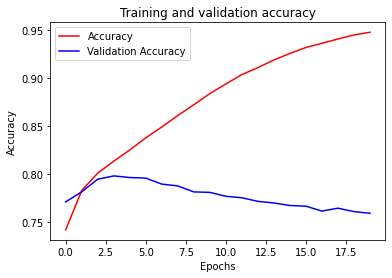

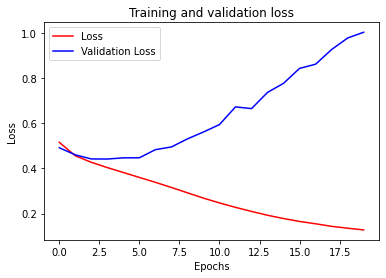

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!